# Experiment 5

## Goal 

Running Gradient descent for multiple variables of the FHN model

Make FHN functions available

In [1]:
import sys
sys.path.insert(0, '../../')

import modules

In [3]:
import torch as t
import numpy as np
from experiment_helper import chop_and_shuffle_data, generate_sequence
from diffusion_gumbel import diffuse_STE
from reaction_diff import rho_STE
from tqdm import tqdm
import matplotlib.pyplot as plt
import os 
from os import path, getcwd
import time
import imageio
import random

set device

In [4]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


generate data

In [7]:
grid = t.zeros((2, 64, 64), device=device)
grid[:] = 25
grid[0, 29:35] = 40

gamma = 0.005
k1 = k1_bar = 0.98
k2 = k2_bar = 0.1
k3 = k3_bar = 0.2

N = 50
num_steps = 30_000
DA = 0.1
DB = 0.4

generate_sequence(
    grid,
    num_steps,
    N,
    use_diffusion=True,
    DA=DA,
    DB=DB,
    use_reaction=True,
    gamma=gamma,
    k1=k1,
    k1_bar=k1_bar,
    k2=k2,
    k2_bar=k2_bar,
    k3=k3,
    k3_bar=k3_bar,
    create_vis=False,
    save_steps=True,
    create_seq=False,
)


  0%|          | 0/30000 [00:00<?, ?it/s]c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\torch\distributions\distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 30000/30000 [04:49<00:00, 103.63it/s]


use last datapoint from the simulation as reference state

In [8]:
data_dir = path.join(getcwd(), "data", "1674650948.418262")
ref_state = t.load(path.join(data_dir, "batch_300", "0.pt"), map_location=device)

torch.Size([2, 64, 64])


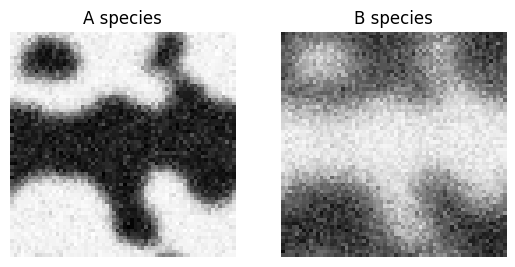

In [9]:
print(ref_state.shape)
fig, axs = plt.subplots(1,2)
axs[0].imshow(ref_state[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[0].set_title("A species")
axs[0].axis("off")
axs[1].imshow(ref_state[1].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("B species")
axs[1].axis("off")
plt.show()

define a distance function

In [13]:
def loss_fn(X, Y):
    return t.log(t.sum((X[:, 0] - Y[:,0])**2 + (X[:, 1] - Y[:,1])**2, dim=(0,1,2)))

define the params and the optimizer

In [37]:
from torch.distributions import uniform
param_sampler = uniform.Uniform(0,1)

k1 = param_sampler.sample().to(device)
k1.requires_grad_()
k2 = param_sampler.sample().to(device)
k2.requires_grad_()
k3 = param_sampler.sample().to(device)
k3.requires_grad_()

optimizer = t.optim.SGD([k1,k2,k3], lr=0.01, momentum=0.9)

define training function

In [38]:
DA = t.tensor(0.1, device=device)
DB = t.tensor(0.4, device=device)
gamma = 0.005
N = 50

if ref_state.ndim == 3:
    ref_state = ref_state.unsqueeze(0)

k1_vals = [k1.detach().cpu().numpy()]
k2_vals = [k2.detach().cpu().numpy()]
k3_vals = [k3.detach().cpu().numpy()]
losses = []

In [39]:
def train_one_epoch():
    X = ref_state.detach().clone()

    # Zero your gradients for every batch!
    optimizer.zero_grad()

    # Make predictions for this batch
    for sim_step in range(1200):
        # run the diffusion step
        X = diffuse_STE(X, N, DA, DB)
        # run the reaction step
        X = rho_STE(X, N, gamma, k1, k1, k2, k2, k3, k3)
        
    # Compute the loss and its gradients
    loss = loss_fn(ref_state, X)
    loss.backward()

    # Adjust learning weights
    optimizer.step()
    
    k1_vals.append(k1.detach().cpu().numpy())
    k2_vals.append(k2.detach().cpu().numpy())
    k3_vals.append(k3.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())

In [ ]:
for i in tqdm(range(200)):
    train_one_epoch()

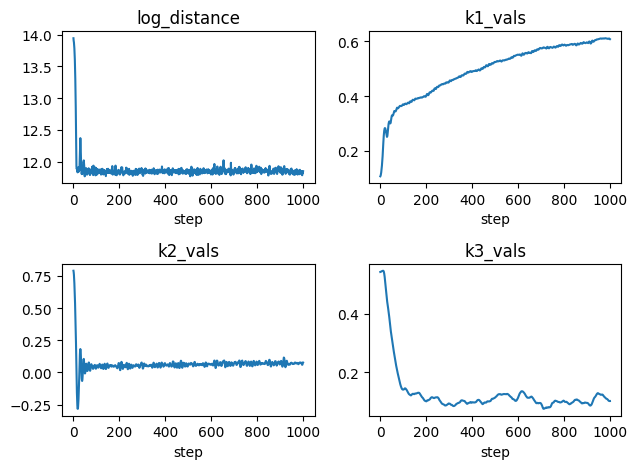

In [42]:
fig, axs = plt.subplots(2,2)

axs[0,0].plot(np.arange(1000), losses)
axs[0,0].set_title("log_distance")
axs[0,0].set_xlabel("step")
axs[0,1].plot(np.arange(1001), k1_vals)
axs[0,1].set_title("k1_vals")
axs[0,1].set_xlabel("step")
axs[1,0].plot(np.arange(1001), k2_vals)
axs[1,0].set_title("k2_vals")
axs[1,0].set_xlabel("step")
axs[1,1].plot(np.arange(1001), k3_vals)
axs[1,1].set_title("k3_vals")
axs[1,1].set_xlabel("step")

fig.tight_layout()
plt.show()

try including snapshot steps to the loss

In [53]:
data_dir = path.join(getcwd(), "data", "1674650948.418262")
ref_state_1 = t.load(path.join(data_dir, "batch_100", "0.pt"), map_location=device)
ref_state_2 = t.load(path.join(data_dir, "batch_200", "0.pt"), map_location=device)
ref_state_stable = t.load(path.join(data_dir, "batch_300", "0.pt"), map_location=device)

torch.Size([2, 64, 64])


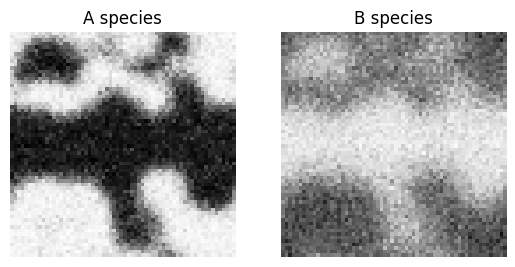

In [54]:
print(ref_state.shape)
fig, axs = plt.subplots(1,2)
axs[0].imshow(ref_state_2[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[0].set_title("A species")
axs[0].axis("off")
axs[1].imshow(ref_state_2[1].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("B species")
axs[1].axis("off")
plt.show()

torch.Size([2, 64, 64])


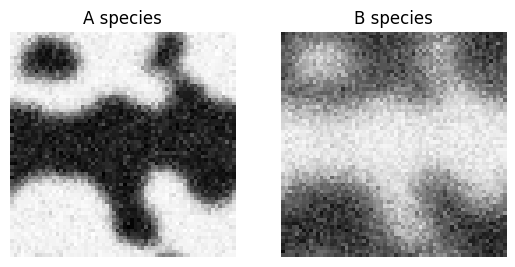

In [55]:
print(ref_state.shape)
fig, axs = plt.subplots(1,2)
axs[0].imshow(ref_state_stable[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[0].set_title("A species")
axs[0].axis("off")
axs[1].imshow(ref_state_stable[1].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("B species")
axs[1].axis("off")
plt.show()

In [64]:
def loss_fn(Y):
    return t.log(t.sum((ref_state_stable-Y)**2))

In [63]:
ref_state_1 = ref_state_1.unsqueeze(0)
ref_state_2 = ref_state_2.unsqueeze(0)
ref_state_stable = ref_state_stable.unsqueeze(0)
X = t.concat((ref_state_1, ref_state_2, ref_state_stable), dim=0)
X.shape

torch.Size([3, 2, 64, 64])

In [92]:
from torch.distributions import uniform
param_sampler = uniform.Uniform(0,1)

k1 = param_sampler.sample().to(device)
k1.requires_grad_()
k2 = param_sampler.sample().to(device)
k2.requires_grad_()
k3 = param_sampler.sample().to(device)
k3.requires_grad_()

optimizer = t.optim.SGD([
        {'params': [k1], 'lr': 0.01},
        {'params': [k2], 'lr': 0.001},
        {'params': [k3], 'lr': 0.1}
    ], momentum=0.9)

In [93]:
DA = t.tensor(0.1, device=device)
DB = t.tensor(0.4, device=device)
gamma = 0.005
N = 50

if ref_state.ndim == 3:
    ref_state = ref_state.unsqueeze(0)

k1_vals = [k1.detach().cpu().numpy()]
k2_vals = [k2.detach().cpu().numpy()]
k3_vals = [k3.detach().cpu().numpy()]
losses = []

In [94]:
for i in tqdm(range(100)):
    Y = X.detach().clone()

    # Zero your gradients for every batch!
    optimizer.zero_grad()

    # Make predictions for this batch
    for sim_step in range(1000):
        # run the diffusion step
        Y = diffuse_STE(Y, N, DA, DB)
        # run the reaction step
        Y = rho_STE(Y, N, gamma, k1, k1, k2, k2, k3, k3)
        
    # Compute the loss and its gradients
    loss = loss_fn(Y)
    loss.backward()

    # Adjust learning weights
    optimizer.step()
    
    with t.no_grad():
        k1 = k1.clamp(0, 1)
        k1.requires_grad_()
        k2 = k2.clamp(0, 1)
        k2.requires_grad_()
        k3 = k3.clamp(0, 1)
        k3.requires_grad_()
    
    k1_vals.append(k1.detach().cpu().numpy())
    k2_vals.append(k2.detach().cpu().numpy())
    k3_vals.append(k3.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())

100%|██████████| 100/100 [20:49<00:00, 12.49s/it]


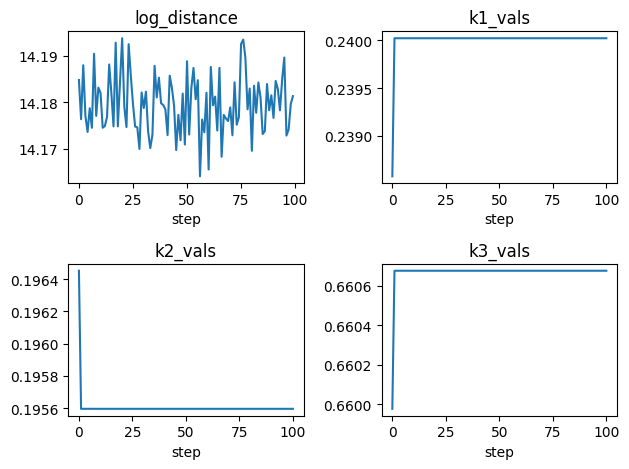

In [95]:
fig, axs = plt.subplots(2,2)

axs[0,0].plot(np.arange(100), losses)
axs[0,0].set_title("log_distance")
axs[0,0].set_xlabel("step")
axs[0,1].plot(np.arange(101), k1_vals)
axs[0,1].set_title("k1_vals")
axs[0,1].set_xlabel("step")
axs[1,0].plot(np.arange(101), k2_vals)
axs[1,0].set_title("k2_vals")
axs[1,0].set_xlabel("step")
axs[1,1].plot(np.arange(101), k3_vals)
axs[1,1].set_title("k3_vals")
axs[1,1].set_xlabel("step")

fig.tight_layout()
plt.show()